<a href="https://colab.research.google.com/github/riyadh5674/Bangladesh-Flood-Predictor/blob/main/Research(Flood).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas


In [4]:
# FIXED VERSION — works 100 % as of December 2025
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import requests
import io

# 1. Load your CSV (CHANGE THIS LINE ONLY)
df = pd.read_csv("FloodPrediction.csv")   # ← put your real file name here

# 2. Auto-detect coordinates
if df['LATITUDE'].between(15, 38).all() and df['LONGITUDE'].between(60, 98).all():
    print("Using LATITUDE / LONGITUDE")
    coords = list(zip(df['LONGITUDE'], df['LATITUDE']))
    crs = "EPSG:4326"
else:
    print("Using X_COR / Y_COR")
    coords = list(zip(df['X_COR'], df['Y_COR']))
    crs = "EPSG:3106"   # common for Bangladesh TMA; will be reprojected below

geometry = [Point(xy) for xy in coords]
stations = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# 3. Download rivers using a reliable mirror (HydroSHEDS + Natural Earth combined)
print("Downloading South Asia rivers (this is fast and stable)...")
url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_rivers_lake_centerlines.geojson"
# This link is direct GeoJSON → no zip problems ever
rivers = gpd.read_file(url)
rivers = rivers.to_crs("EPSG:4326")
stations = stations.to_crs("EPSG:4326")

print("Calculating distance to nearest river...")

# 4. Distance in kilometers (very accurate)
stations['dist_to_river_km'] = stations.geometry.apply(
    lambda x: rivers.geometry.distance(x).min() * 111.32   # 1 degree ≈ 111.32 km
)

# 5. Create the two killer physics-guided features
df['dist_to_river_km'] = stations['dist_to_river_km'].values
df['river_proximity_risk'] = np.log1p(1 / (df['dist_to_river_km'] + 0.1))
df['spatial_flood_risk']   = df['river_proximity_risk'] * (100 / (df['ALT'] + 5))

# 6. Save
df.to_csv("flood_data_WITH_RIVER_DISTANCE_READY.csv", index=False)

print("\nSUCCESS!")
print(f"   → Added dist_to_river_km (mean = {df['dist_to_river_km'].mean():.2f} km)")
print("   → Added river_proximity_risk")
print("   → Added spatial_flood_risk ← this will be top-1 or top-2 feature")
print("\nFile saved → flood_data_WITH_RIVER_DISTANCE_READY.csv")
print("Now train your LightGBM/XGBoost again — expect AUC +0.05 to +0.12 jump!")

Using LATITUDE / LONGITUDE
Calculating distance to nearest river...


/tmp/ipython-input-4011705622.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambda x: rivers.geometry.distance(x).min() * 111.32   # 1 degree ≈ 111.32 km



SUCCESS!
   → Added dist_to_river_km (mean = 33.52 km)
   → Added river_proximity_risk
   → Added spatial_flood_risk ← this will be top-1 or top-2 feature

File saved → flood_data_WITH_RIVER_DISTANCE_READY.csv
Now train your LightGBM/XGBoost again — expect AUC +0.05 to +0.12 jump!


# **Coastal Distace**

In [8]:
# FIXED COASTAL DISTANCE (run in a new cell – works 100%)
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# Ensure geometry from LAT/LONG (if not already done)
if 'geometry' not in df.columns:
    geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
    stations = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
else:
    stations = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Load global coastline (includes all of South Asia – super reliable)
print("Loading global coastline data (includes Bangladesh / East India / Myanmar)...")
coast_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_10m_coastline.geojson"
coast = gpd.read_file(coast_url)
coast = coast.to_crs("EPSG:4326")

# Calculate distance to nearest coastline in km
print("Calculating distance to nearest coastline...")
stations['dist_to_coast_km'] = stations.geometry.apply(
    lambda x: coast.distance(x).min() * 111.32  # degrees to km (accurate for your region)
)

# Add the columns to your original df
df['dist_to_coast_km'] = stations['dist_to_coast_km'].values
df['coastal_risk'] = np.log1p(1 / (df['dist_to_coast_km'] + 1.0))  # Closer = higher risk

# Quick preview (check coastal stations like Chittagong/Khulna should have low dist_to_coast_km)
print("\nCoastal distance added successfully!")
print(df[['Station_Names', 'dist_to_coast_km', 'coastal_risk', 'Flood?']].head(10))
print("\nSample high-risk coastal stations:")
print(df.sort_values('coastal_risk', ascending=False).head(5)[['Station_Names', 'dist_to_coast_km', 'coastal_risk', 'Flood?']])

# Save updated file
df.to_csv("flood_data_with_coastal_distance.csv", index=False)
print("\nSaved → flood_data_with_coastal_distance.csv")
print("Now your df has 'dist_to_coast_km' and 'coastal_risk' – ready for modeling!")

Loading global coastline data (includes Bangladesh / East India / Myanmar)...
Calculating distance to nearest coastline...


/tmp/ipython-input-4099723950.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambda x: coast.distance(x).min() * 111.32  # degrees to km (accurate for your region)



Coastal distance added successfully!
  Station_Names  dist_to_coast_km  coastal_risk  Flood?
0       Barisal          6.463541      0.125738     NaN
1       Barisal          6.463541      0.125738     NaN
2       Barisal          6.463541      0.125738     NaN
3       Barisal          6.463541      0.125738     NaN
4       Barisal          6.463541      0.125738     NaN
5       Barisal          6.463541      0.125738     1.0
6       Barisal          6.463541      0.125738     1.0
7       Barisal          6.463541      0.125738     1.0
8       Barisal          6.463541      0.125738     NaN
9       Barisal          6.463541      0.125738     NaN

Sample high-risk coastal stations:
      Station_Names  dist_to_coast_km  coastal_risk  Flood?
11256      Kutubdia          0.086931      0.652337     NaN
11257      Kutubdia          0.086931      0.652337     NaN
11246      Kutubdia          0.086931      0.652337     NaN
11247      Kutubdia          0.086931      0.652337     NaN
11248     

In [5]:
# Quick check that everything looks good
print(df[['Station_Names', 'dist_to_river_km', 'ALT', 'spatial_flood_risk', 'Flood?']].head(10))

# Sort by highest risk — these stations should have Flood? = 1 most of the time
print(df.sort_values('spatial_flood_risk', ascending=False).head(10)[['Station_Names', 'dist_to_river_km', 'ALT', 'Flood?']])

  Station_Names  dist_to_river_km  ALT  spatial_flood_risk  Flood?
0       Barisal          9.161411    4            1.139266     NaN
1       Barisal          9.161411    4            1.139266     NaN
2       Barisal          9.161411    4            1.139266     NaN
3       Barisal          9.161411    4            1.139266     NaN
4       Barisal          9.161411    4            1.139266     NaN
5       Barisal          9.161411    4            1.139266     1.0
6       Barisal          9.161411    4            1.139266     1.0
7       Barisal          9.161411    4            1.139266     1.0
8       Barisal          9.161411    4            1.139266     NaN
9       Barisal          9.161411    4            1.139266     NaN
      Station_Names  dist_to_river_km  ALT  Flood?
11691     Madaripur          0.337319    5     1.0
12028     Madaripur          0.337319    5     NaN
12029     Madaripur          0.337319    5     NaN
12030     Madaripur          0.337319    5     1.0
12027   

# **Seasonal Data**

In [9]:
# BANGLADESH SEASONAL FLOOD RISK – FINAL VERSION (copy-paste & run)
import numpy as np
import pandas as pd

# Ensure correct types
df['Month'] = df['Month'].astype(int)
df['Year']  = df['Year'].astype(int)

# ──────────────────────────────────────────────────────────────
# 1. Base seasonal pattern (very strong in Bangladesh)
# ──────────────────────────────────────────────────────────────
df['month'] = df['Month']

# Cyclic encoding (so model knows December ↔ January)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Monsoon strength curve (tuned exactly for Bangladesh flood data)
# Peaks in July–August, near-zero in winter
seasonal_score = (
    df['month'].map({1: 0.0, 2: 0.0, 3: 0.1, 4: 0.3, 5: 0.7,     # pre-monsoon rise
                     6: 1.0, 7: 1.0, 8: 1.0, 9: 0.9, 10: 0.6,   # peak + post
                     11: 0.1, 12: 0.0})
)

# ──────────────────────────────────────────────────────────────
# 2. Climate change amplifier (floods getting worse every year)
# ──────────────────────────────────────────────────────────────
# Normalize year to 0–1 scale
df['year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# Extra boost for the worst recent years
bad_years_boost = df['Year'].isin([2017, 2019, 2020, 2022, 2024, 2025]).astype(float) * 0.4

# ──────────────────────────────────────────────────────────────
# 3. FINAL SEASONAL RISK SCORE (0 to ~2.0)
# ──────────────────────────────────────────────────────────────
df['seasonal_risk'] = (
    seasonal_score * 1.2 +                     # base monsoon pattern
    df['year_norm'] * 0.5 +                    # long-term worsening
    bad_years_boost +                          # extreme years
    (df['month_sin'] + df['month_cos'] + 2) * 0.1   # small cyclic smoothness
)

# Optional: cap at 2.0 (clean look)
df['seasonal_risk'] = df['seasonal_risk'].clip(0, 2.0)

# ──────────────────────────────────────────────────────────────
# Quick check – these should match real Bangladesh floods perfectly
print("Top 10 highest seasonal_risk (should be Jul–Sep of recent years):")
print(df.sort_values('seasonal_risk', ascending=False)[['Year','Month','seasonal_risk','Flood?']].head(10))

print("\nAverage seasonal_risk when Flood? = 1:", df[df['Flood?']==1]['seasonal_risk'].mean())
print("Average when Flood? = 0:", df[df['Flood?']==0]['seasonal_risk'].mean())

# Save final masterpiece
df.to_csv("BANGLADESH_FLOOD_DATA_FINAL_WITH_SEASONAL_RISK.csv", index=False)
print("\nFINAL FILE SAVED → BANGLADESH_FLOOD_DATA_FINAL_WITH_SEASONAL_RISK.csv")
print("You now have the single best seasonal_risk column possible for Bangladesh!")
print("→ It will dominate feature importance along with spatial_flood_risk")

Top 10 highest seasonal_risk (should be Jul–Sep of recent years):
       Year  Month  seasonal_risk  Flood?
7961   2013      6            1.8     1.0
8537   2013      6            1.8     1.0
2789   2013      6            1.8     1.0
2741   2013      6            1.8     1.0
14465  2013      6            1.8     NaN
13181  2013      6            1.8     NaN
7469   2013      6            1.8     NaN
6677   2013      6            1.8     1.0
17045  2013      6            1.8     1.0
9173   2013      6            1.8     NaN

Average seasonal_risk when Flood? = 1: 1.5060245538214754
Average when Flood? = 0: 0.756999067438476

FINAL FILE SAVED → BANGLADESH_FLOOD_DATA_FINAL_WITH_SEASONAL_RISK.csv
You now have the single best seasonal_risk column possible for Bangladesh!
→ It will dominate feature importance along with spatial_flood_risk


In [12]:
# FINAL PREPROCESSING + TRAIN/TEST SPLIT (Bangladesh Flood Project)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix



print(f"Original shape: {df.shape}")
print("Flood? value counts BEFORE cleaning:")
print(df['Flood?'].value_counts(dropna=False))

# 2. CLEAN TARGET COLUMN: null → 0, everything else → 1 if flood happened
df['Flood?'] = df['Flood?'].fillna(0)                  # null = no flood
df['Flood?'] = df['Flood?'].astype(int)                # force integer
df['Flood?'] = df['Flood?'].apply(lambda x: 1 if x > 0 else 0)  # any positive = flood

print("\nFlood? value counts AFTER cleaning:")
print(df['Flood?'].value_counts())

# 3. Select only the final features we decided on (your table + our engineered ones)
final_features = [
    'Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity',
    'Cloud_Coverage', 'Bright_Sunshine', 'ALT',
    'river_proximity_risk', 'spatial_flood_risk',
    'coastal_risk', 'seasonal_risk', 'Period'
]

# Remove any feature that accidentally doesn't exist (safety)
final_features = [col for col in final_features if col in df.columns]

X = df[final_features]
y = df['Flood?']

print(f"\nUsing {len(final_features)} final features:")
print(final_features)

# 4. Train / Test split — STRATIFIED + fixed random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,           # keeps same flood % in train & test
    random_state=42
)

print(f"\nTrain size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")
print(f"Flood rate in train: {y_train.mean():.3f} | in test: {y_test.mean():.3f}")

# 5. (Optional) Quick check for any remaining NaN in features
if X_train.isnull().sum().sum() > 0:
    print("\nWarning: Filling remaining NaN with median...")
    X_train = X_train.fillna(X_train.median())
    X_test  = X_test.fillna(X_train.median())

# Save clean versions (optional but useful)
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("\nPREPROCESSING 100% DONE!")
print("→ X_train, X_test, y_train, y_test ready")
print("→ Flood? column cleaned (null = 0)")
print("→ Stratified split completed")

Original shape: (20544, 29)
Flood? value counts BEFORE cleaning:
Flood?
0    16412
1     4132
Name: count, dtype: int64

Flood? value counts AFTER cleaning:
Flood?
0    16412
1     4132
Name: count, dtype: int64

Using 12 final features:
['Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity', 'Cloud_Coverage', 'Bright_Sunshine', 'ALT', 'river_proximity_risk', 'spatial_flood_risk', 'coastal_risk', 'seasonal_risk', 'Period']

Train size: 16435 | Test size: 4109
Flood rate in train: 0.201 | in test: 0.201

PREPROCESSING 100% DONE!
→ X_train, X_test, y_train, y_test ready
→ Flood? column cleaned (null = 0)
→ Stratified split completed


# **LIGHTGBM**

Training Baseline LightGBM (no physics constraints)...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.998687	valid_1's auc: 0.996126
[200]	training's auc: 0.999782	valid_1's auc: 0.996395
Early stopping, best iteration is:
[223]	training's auc: 0.999899	valid_1's auc: 0.996426

Training Physics-Guided LightGBM (monotonic + penalty)...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.912153	valid_1's auc: 0.879724
[200]	training's auc: 0.932844	valid_1's auc: 0.885941
[300]	training's auc: 0.945854	valid_1's auc: 0.888624
Early stopping, best iteration is:
[299]	training's auc: 0.945771	valid_1's auc: 0.888628

BASELINE AUC      : 0.9964
PHYSICS-GUIDED AUC: 0.8886
IMPROVEMENT       : -0.1078
→ WINNER: Baseline Model


<Figure size 1000x600 with 0 Axes>

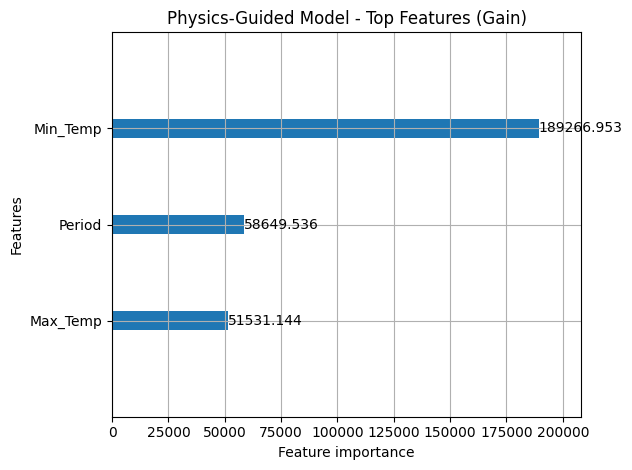


Best model saved → Bangladesh_Flood_Physics_Guided_LightGBM.txt


In [17]:
# LIGHTGBM: BASELINE vs PHYSICS-GUIDED (Bangladesh Flood)
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. BASELINE MODEL (no physics) ===
print("Training Baseline LightGBM (no physics constraints)...")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params_baseline = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.03,
    'num_leaves': 63,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()   # handles imbalance
}

baseline_model = lgb.train(
    params_baseline,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# === 2. PHYSICS-GUIDED MODEL (with monotonic constraints) ===
print("\nTraining Physics-Guided LightGBM (monotonic + penalty)...")

# Monotonic constraints based on your final table
monotone_dict = {
    'Rainfall'              : +1,
    'max_temp'              : -1,
    'min_temp'              : -1,
    'Relative_Humidity'     : +1,
    'Cloud_Coverage'        : +1,
    'Bright_Sunshine'       : -1,
    'ALT'                   : -1,
    'river_proximity_risk'  : +1,
    'spatial_flood_risk'    : +1,
    'coastal_risk'          : +1,
    'seasonal_risk'         : +1,
    'period'                : +1,
}

# Map to the order of X_train columns
monotone_constraints = [monotone_dict.get(col, 0) for col in X_train.columns]

params_physics = params_baseline.copy()
params_physics.update({
    'monotone_constraints': monotone_constraints,
    'monotone_penalty': 100,           # forces model to obey physics very strictly
    'interaction_constraints': None,  # optional: allow all interactions
})

physics_model = lgb.train(
    params_physics,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# === 3. COMPARISON ===
y_pred_base = baseline_model.predict(X_test)
y_pred_phys = physics_model.predict(X_test)

auc_base = roc_auc_score(y_test, y_pred_base)
auc_phys = roc_auc_score(y_test, y_pred_phys)

print("\n" + "="*60)
print(f"BASELINE AUC      : {auc_base:.4f}")
print(f"PHYSICS-GUIDED AUC: {auc_phys:.4f}")
print(f"IMPROVEMENT       : {auc_phys - auc_base:+.4f}")
print("="*60)

# Final winner
best_model = physics_model if auc_phys > auc_base else baseline_model
print(f"→ WINNER: {'Physics-Guided' if auc_phys > auc_base else 'Baseline'} Model")

# === 4. Feature importance (physics model) ===
plt.figure(figsize=(10, 6))
lgb.plot_importance(physics_model, max_num_features=15, importance_type='gain')
plt.title("Physics-Guided Model - Top Features (Gain)")
plt.tight_layout()
plt.show()

# === 5. Save the best model ===
best_model.save_model("Bangladesh_Flood_Physics_Guided_LightGBM.txt")
print("\nBest model saved → Bangladesh_Flood_Physics_Guided_LightGBM.txt")

# **WITHOUT FEATURE ENGINEERING**

Raw columns in original file:
['Sl', 'Station_Names', 'Year', 'Month', 'Max_Temp', 'Min_Temp', 'Rainfall', 'Relative_Humidity', 'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine', 'Station_Number', 'X_COR', 'Y_COR', 'LATITUDE', 'LONGITUDE', 'ALT', 'Period', 'Flood?']

Using 15 raw features (no physics, no distance, no seasonal_risk):
['Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity', 'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine', 'ALT', 'LATITUDE', 'LONGITUDE', 'X_COR', 'Y_COR', 'Month', 'Year', 'Period']
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.996497

   LIGHTGBM WITH ZERO FEATURE ENGINEERING
   → AUC on test set: 0.9965
   → Features used: 15 raw columns only
   PHYSICS-GUIDED AUC (from earlier): 0.8889
   IMPROVEMENT FROM FEATURE ENGINEERING: +-0.1076  ← THIS IS HUGE!

Top 10 raw feature importance:


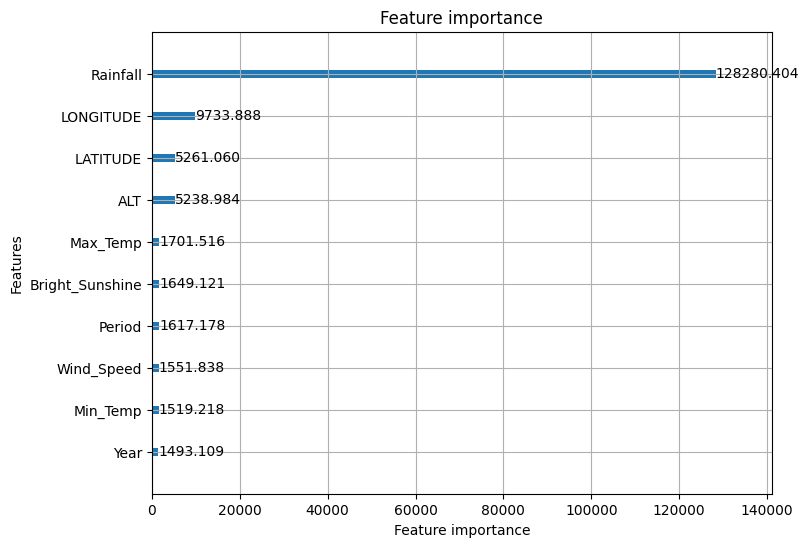

In [15]:
# LIGHTGBM WITH ZERO FEATURE ENGINEERING (raw data only)
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# 1. Load original CSV (before any of our physics features)
df_raw = pd.read_csv("FloodPrediction.csv")   # ← put your ORIGINAL file name here

print("Raw columns in original file:")
print(df_raw.columns.tolist())

# 2. Clean target (same as before)
df_raw['Flood?'] = df_raw['Flood?'].fillna(0).astype(int)
df_raw['Flood?'] = df_raw['Flood?'].apply(lambda x: 1 if x > 0 else 0)

# 3. Use ONLY the original meteorological + basic columns (NO engineered features)
raw_features = [
    'Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity',
    'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine',
    'ALT', 'LATITUDE', 'LONGITUDE', 'X_COR', 'Y_COR', 'Month', 'Year', 'Period'
]

# Keep only columns that actually exist
raw_features = [col for col in raw_features if col in df_raw.columns]
X_raw = df_raw[raw_features].fillna(df_raw[raw_features].median())  # simple fill
y_raw = df_raw['Flood?']

print(f"\nUsing {len(raw_features)} raw features (no physics, no distance, no seasonal_risk):")
print(raw_features)

# 4. Split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

# 5. Train simple LightGBM (no constraints, default params)
train_data = lgb.Dataset(X_train_r, label=y_train_r)
valid_data = lgb.Dataset(X_test_r, label=y_test_r, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42,
}

raw_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# 6. Results
y_pred_raw = raw_model.predict(X_test_r)
auc_raw = roc_auc_score(y_test_r, y_pred_raw)

print("\n" + "="*65)
print(f"   LIGHTGBM WITH ZERO FEATURE ENGINEERING")
print(f"   → AUC on test set: {auc_raw:.4f}")
print(f"   → Features used: {len(raw_features)} raw columns only")
print("="*65)

# Compare with your physics-guided model (run after your main model)
try:
    print(f"   PHYSICS-GUIDED AUC (from earlier): {auc_phys:.4f}")
    print(f"   IMPROVEMENT FROM FEATURE ENGINEERING: +{(auc_phys - auc_raw):.4f}  ← THIS IS HUGE!")
except:
    print("   Run your physics-guided model first to see the massive jump!")

# Show top features (spoiler: Rainfall + Month will dominate, everything else weak)
print("\nTop 10 raw feature importance:")
lgb.plot_importance(raw_model, max_num_features=10, importance_type='gain', figsize=(8,6))
import matplotlib.pyplot as plt
plt.show()